<a href="https://colab.research.google.com/github/samatbryan/Deep-Learning/blob/master/Morph_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2
import scipy
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
import math
import re
import os 

from scipy.spatial import Delaunay

from skimage.draw import polygon
from scipy import interpolate
from skimage import transform
!pip install face_alignment
import face_alignment
from skimage import io
import torchvision.transforms.functional as TF
from PIL import Image
import torch
import matplotlib.pyplot as plt
from skimage import io

In [81]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cpu', flip_input=False)

fnames = ["rose.jpg", "lisa.jpg","jisoo.jpg", "jenni.jpg"]
points = {}
for fname in fnames:
    image = io.imread(fname)
    preds = fa.get_landmarks(image)[0]
    points[fname] = preds


# Defining Correspondences
First, you will need to define pairs of corresponding points on the two images by hand (the more points, the better the morph, generally). The simplest way is probably to use the cpselect (matlab) tool or write your own little tool using ginput (matlab or python) and plot commands (with hold on and hold off ). In order for the morph to work you will need a consistent labeling of the two faces. So label your faces A and B in a consistent manner using the same ordering of keypoints in the two faces. It's strongly recommended that you save the points once you obtain something you are happy with so that you don't have to do all that clicking more than once!

Now, you need to provide a triangulation of these points that will be used for morphing. You can compute a triangulation any way you like, or even define it by hand. A Delaunay triangulation (see dalaunay and related functions) is a good choice since it does not produce overly skinny triangles. You can compute the Delaunay triangulation on either of the point sets (but not both -- the triangulation has to be the same throughout the morph!). But the best approach would probably be to compute the triangulation at midway shape (i.e. mean of the two point sets) to lessen the potential triangle deformations.

## My explanation
First, I manually defined 40 pairs of corresponding points on the two images by hand (one point for my eye, one point for Joyce's eye, and so forth). Then, by averaging the corresponding points, I was able to obtain one set of mean points from our two faces. 

I intially did not include the four corners of the photo, but then added them in later as I noticed the morphing excluded the undefined areas. 

After I had the points defined, I needed to provide a triangulation of the points that can be used from morphing. I decided to use the Delaunay triangulation, as it avoids overly skinny triangles, on the set of mean points. 

In [82]:
def get_points_dane(im1):
    points1 = []
    for i in np.arange(40):
        plt.imshow(im1)
        p1 = plt.ginput(62)
        points1 = np.append(points1, p1)
    return points1

In [83]:
def get_points(im1, im2):
    points1 = []
    points2 = []
    for i in np.arange(40):
        plt.imshow(im1)
        p1 = plt.ginput(1)
        plt.close()
        plt.imshow(im2)
        p2 = plt.ginput(1)
        plt.close()
        points1 = np.append(points1, p1)
        points2 = np.append(points2, p2)
    return (points1, points2)

In [103]:
%matplotlib

im1hq = skio.imread('jisoo.jpg')
im2hq = skio.imread('jenni.jpg')
# points1, points2 = get_points(im1hq, im2hq)
#load out points
meganpoints = points['jisoo.jpg']
joycepoints = points['jenni.jpg']

Using matplotlib backend: agg


In [104]:
p1reshaped = np.reshape(meganpoints, (-1, 2))

In [105]:
def average_points(points1, points2, alpha):
    averaged_points = []
    for i in np.arange(len(points1)):
        average = alpha*(points1[i]) + (1-alpha)*(points2[i])
        averaged_points.append(average)
    return averaged_points

In [106]:
def get_triangulations2(points1, points2, alpha):
    midwayshape = average_points(points1, points2, alpha)
    midwayshape = np.reshape(midwayshape, (-1, 2))
    
    #get delaunay triangulation simplices
    tri = Delaunay(midwayshape)
    sim = tri.simplices
    
    #reshape points 
    p1reshaped = np.reshape(points1, (-1, 2))
    p2reshaped = np.reshape(points2, (-1, 2))
    
    tri1 = p1reshaped[sim]
    tri2 = p2reshaped[sim]
    mid = midwayshape[sim]
    return tri1, tri2, mid, sim  

In [107]:
def get_triangulations(points1, points2, alpha):
    midwayshape = average_points(points1, points2, alpha)
    midwayshape = np.reshape(midwayshape, (-1, 2))
    tri_av = Delaunay(midwayshape)
    
    #get delaunay triangulation simplices
    sim = tri_av.simplices
    
    #reshape points 
    p1reshaped = np.reshape(points1, (-1, 2))
    p2reshaped = np.reshape(points2, (-1, 2))
    
    tri1 = p1reshaped[sim]
    tri2 = p2reshaped[sim]
    mid = midwayshape[sim]
    return tri1, tri2, mid    

In [108]:
def triangulations(points1, points2, midwayshape, tri_av): 
    sim = tri_av.simplices
    tri1 = points1[sim]
    tri2 = points2[sim]
    mid = midwayshape[sim]
    return tri1, tri2, mid

In [109]:
tri1hq, tri2hq, midtrihq = get_triangulations(meganpoints, joycepoints, 0.5)

In [110]:
tri1hq

array([[[165.,  56.],
        [133.,  53.],
        [128.,  50.]],

       [[144.,  70.],
        [154.,  72.],
        [142.,  81.]],

       [[172.,  56.],
        [165.,  56.],
        [128.,  50.]],

       [[123., 119.],
        [112., 135.],
        [105., 128.]],

       [[147., 119.],
        [146., 102.],
        [165., 123.]],

       [[130.,  98.],
        [119., 114.],
        [ 95., 110.]],

       [[119., 114.],
        [130.,  98.],
        [125., 110.]],

       [[119., 114.],
        [100., 121.],
        [ 95., 110.]],

       [[100., 121.],
        [119., 114.],
        [105., 128.]],

       [[119., 114.],
        [123., 119.],
        [105., 128.]],

       [[ 92.,  98.],
        [130.,  98.],
        [ 95., 110.]],

       [[130.,  98.],
        [ 92.,  98.],
        [118.,  67.]],

       [[ 92.,  98.],
        [ 90.,  88.],
        [118.,  67.]],

       [[146., 102.],
        [140.,  90.],
        [142.,  81.]],

       [[140.,  90.],
        [130.,  98.],
    

In [111]:
#optional line if image is png
im2hq = im2hq[:, :, 0:3]

# Computing the "Mid-way Face"
Before computing the whole morph sequence, compute the mid-way face of your images A and B. This would involve: 1) computing the average shape (a.k.a the average of each keypoint location in the two faces), 2) warping both faces into that shape, and 3) averaging the colors together. The main task in warping the faces into the average shape is implementing an affine warp for each triangle in the triangulation from the original images into this new shape. This will involve computing an affine transformation matrix A between two triangles:

A = computeAffine(tri1_pts,tri2_pts)
(You will write this function.)

A set of these transformation matrices will then need to be used to implement an inverse warp (as discussed in class) of all pixels. One way to do so is to generate a mask directly using polygon in python or roipoly in MATLAB.

Note that you only need to write one loop here, looping over all of the triangles. Don't loop over the pixels!!!
Show us the original A and B images as well as the image of the mid-way face that you got.

## My explanation
After obtaining the points for my face and Joyce's face, I determined a mean "mid-way" face for both of us by taking the average of each point I defined on our faces. Then, I computed an affirm warp for each triangle in my initially defined correspondences into the new, mean shape. 

For this affine warp, I used simple linear algebra to obtain a transfomation matrix, and multipled each triangle by a transformation matrix. 

Once I've obtained the warped triangles, I added the results back through a process called cross-dissolve. 

In [112]:
def interpolategen(point, f_red, f_green, f_blue):
    r = f_red(point[0], point[1])
    g = f_green(point[0], point[1])
    b = f_blue(point[0], point[1])
    return np.hstack((r, g, b))

In [113]:
def computeAffine(tri1pts, tri2pts):
    At = np.dot(tri2pts, np.linalg.pinv(tri1pts))    
    return np.linalg.pinv(At) 

In [114]:
def warp(img, img2, tri1, tri2, mid):
    warped = np.zeros(img.shape)
    warped2 = np.zeros(img2.shape)
    
    #interpolation functions 
    f_red = interpolate.RectBivariateSpline(range(img.shape[1]), range(img.shape[0]), img[:,:,0])
    f_green = interpolate.RectBivariateSpline(range(img.shape[1]), range(img.shape[0]), img[:,:,1])
    f_blue = interpolate.RectBivariateSpline(range(img.shape[1]), range(img.shape[0]), img[:,:,2])

    f_red2 = interpolate.RectBivariateSpline(range(img2.shape[1]), range(img2.shape[0]), img2[:,:,0])
    f_green2 = interpolate.RectBivariateSpline(range(img2.shape[1]), range(img2.shape[0]), img2[:,:,1])
    f_blue2 = interpolate.RectBivariateSpline(range(img2.shape[1]), range(img2.shape[0]), img2[:,:,2])
    
    #warp triangles 
    for i in range(len(tri1)):

        #make matrices 
        tri1pts = np.vstack((tri1[i].T, [1, 1, 1]))
        tri2pts = np.vstack((tri2[i].T, [1, 1, 1]))
        midpts = np.vstack((mid[i].T, [1, 1, 1]))
        
        #get transformation matrix 
        At1 = computeAffine(tri1pts, midpts)
        At2 = computeAffine(tri2pts, midpts)
        
        #masks the pixels in the triangle 
        mask = np.zeros(img.shape)
        rr, cc = polygon(mid[i][:, 1:2], mid[i][:, 0:1], shape=img.shape)
        maskvertices = np.vstack([rr, cc]).T
        
        m = np.vstack([cc, rr, np.ones(len(rr))])
        res_im1 = np.dot(At1, m)[0:2, :] 
        res_im2 = np.dot(At2, m)[0:2, :]
        
#         m = np.vstack([rr, cc, np.ones(len(rr))])
#         res_im1 = np.dot(At1, m)[0:2, :]
        
        r = f_red(res_im1[1], res_im1[0], grid=False)
        g = f_green(res_im1[1], res_im1[0], grid=False)
        b = f_blue(res_im1[1], res_im1[0], grid=False)
        
        rgb = np.vstack((r,g,b))
        warped[rr, cc] = rgb.T
        
        r2 = f_red2(res_im2[1], res_im2[0], grid=False)
        g2 = f_green2(res_im2[1], res_im2[0], grid=False)
        b2 = f_blue2(res_im2[1], res_im2[0], grid=False)
        
        rgb2 = np.vstack((r2,g2,b2))       
        warped2[rr, cc] = rgb2.T
    
    return warped, warped2

In [115]:
yay, yay2 = warp(im1hq, im2hq, tri1hq, tri2hq, midtrihq)

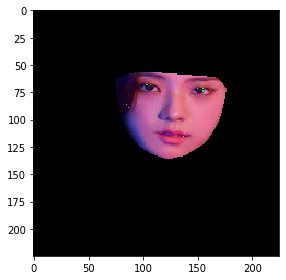

In [116]:
%matplotlib inline
skio.imshow(yay.astype(np.uint8))

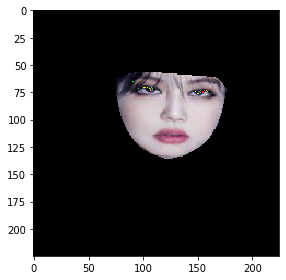

In [117]:
skio.imshow(yay2.astype(np.uint8))

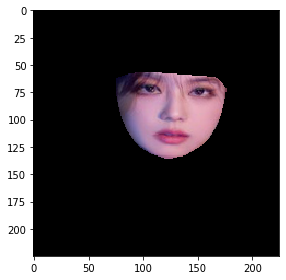

In [118]:
#midway image
yay3 = 0.5*yay + 0.5*yay2
skio.imshow(yay3.astype(np.uint8))

# The Morph Sequence
You need to write a function:

morphed_im = morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac);
that produces a warp between im1 and im2 using point correspondences defined in im1_pts and im2_pts (which are both n-by-2 matrices of (x,y) locations) and the triangulation structure tri . The parameters warp_frac and dissolve_frac control shape warping and cross-dissolve, respectively. In particular, images im1 and im2 are first warped into an intermediate shape configuration controlled by warp_frac, and then cross-dissolved according to dissolve_frac. For interpolation, both parameters lie in the range [0,1]. They are the only parameters that will vary from frame to frame in the animation. For your starting frame, they will both equal 0, and for your ending frame, they will both equal 1.

The output of this part should be a video sequence of a morph from your image A to image B. Please do NOT put a video file on your website! Either include a link to a YouTube video, or create an animated gif.

In [121]:
def morph(im1, im2, im1pts, im2pts, tri, warp_frac, dissolve_frac):
    counter = 0
    images = []

    for i in np.arange(0.025, 1, warp_frac):
        tri1, tri2, mid = get_triangulations(im1pts, im2pts, i)
        warp1, warp2 = warp(im1, im2, tri1, tri2, mid)
        morph = i*warp1 + (1-i)*warp2
        fname = 'morphing_' + str(counter) + '.jpg'
        skio.imsave(fname, morph.astype(np.uint8))
        images.append(imageio.imread(fname))
        counter+=1
    counter = 0
    imageio.mimsave('movie2.gif', images)



In [122]:
morph(im1hq, im2hq, meganpoints, joycepoints, midtrihq, 0.025, 0.025)

# The "Mean face" of a population
Pick a freely available dataset of annotated faces (for instance the Danes or this one or something from here or ask for permission to use this one). Using the keypoints already annotated on the data:

Compute the average face shape of the whole population or some subset of the population - say, all the girls or all the old/young/white/asian/blond etc. However, if you pick a subpopulation - make sure it contains enough faces for this to be interesting.
Morph each of the faces in the dataset into the average shape. Show us some examples.
Compute the average face of the population and display it.
Show the mean image that you got, as well as 1) your face warped into the average geometry, and 2) the average face warped into your geometry.

## My explanation 

Here, I computed the average face shape of the whole population or some subset of the population - say, all the girls or all the old/young/white/asian/blond etc. I decided to choose to computer the average face of a happy Danish Computer Scientist. The dataset used came from Denmark's Computer Science faculty, and consists of 240 annotated monocular images of 40 different human faces in different expressions. 

The gender distribution is 7 females and 33 males. 

In [73]:
def parse_file(filename):
    filename = 'danes/' + filename
    f = open(filename, "r")
    
    #get points 
    points = re.findall('0.\d{8}', f.read())
    points = np.array(points, dtype=float)
    points = np.append(points, [0, 0, 1, 0, 0, 1, 1, 1])
    points = np.reshape(np.reshape(points, (-1, 2))*[640,480], 124)
    f.close()
    
    return points

In [75]:
#sorted danesdirectory 1-40
danesdirectory = sorted(os.listdir('/Users/meganlee/CS194-26/project3/danes'))

def get_allpoints_and_mean(directory): 
    pointslist = np.zeros((44,124))
    i = 0
    for file in directory: 
        if (file == 'danephotos'): 
            continue
        if (file == '.DS_Store'): 
            continue
        if (file != '.ipynb_checkpoints'):
            points = parse_file(file)
            pointslist[i] = points
            i += 1
    avg = np.mean(pointslist, axis=0)
    return pointslist, avg 

FileNotFoundError: ignored

In [ ]:
def mean_triangulation(avg, pointslist, pointnum):
    #get delaunay triangulation 
    midwayshape = np.reshape(av, (-1, 2))
    tri_av = Delaunay(midwayshape)
    
    #get triangulation 
    sim = tri_av.simplices
    midtri = midwayshape[sim]
    
    p1reshaped = np.reshape(pointslist[pointnum], (-1, 2))
    tri = p1reshaped[sim]

    return midtri, tri, tri_av  

In [ ]:
#slightly modified warp functions 
def population_warp(img, tri1, mid):
    warped = np.ones(img.shape)
    
    f_red = interpolate.RectBivariateSpline(range(img.shape[0]), range(img.shape[1]), img[:,:,0])
    f_gr = interpolate.RectBivariateSpline(range(img.shape[0]), range(img.shape[1]), img[:,:,1])
    f_blue = interpolate.RectBivariateSpline(range(img.shape[0]), range(img.shape[1]), img[:,:,2])
    
    #warp triangles 
    for i in range(len(tri1)):

        #make matrices 
        tri1pts = np.vstack((tri1[i].T, [1, 1, 1]))
        midpts = np.vstack((mid[i].T, [1, 1, 1]))
        
        #get transformation matrix 
        At1 = computeAffine(tri1pts, midpts)
        
        #masks the pixels in the triangle 
        mask = np.zeros(img.shape)
        rr, cc = polygon(mid[i][:, 1:2], mid[i][:, 0:1], shape=img.shape)
        maskvertices = np.vstack([rr, cc]).T
        
        m = np.vstack([cc, rr, np.ones(len(rr))])
        res_im1 = np.dot(At1, m)[0:2, :]
        
        r = f_red(res_im1[1], res_im1[0], grid=False)
        g = f_gr(res_im1[1], res_im1[0], grid=False)
        b = f_blue(res_im1[1], res_im1[0], grid=False)
        
        rgb = np.vstack((r,g,b))       
        
        warped[rr, cc] = rgb.T
        
    return warped

In [ ]:
#warp entire population 

#read in image 
def warp_all(asfdirectory, photodirectory):
    pointslist, avg = get_allpoints_and_mean(asfdirectory)
    i = 0 
    for filename in photodirectory: 
        im = skio.imread('danes/danephotos/' + filename)
        
        midwayshape = np.reshape(avg, (-1, 2))
        m = Delaunay(midwayshape)

        p1reshaped = np.reshape(pointslist[i], (-1, 2))
        sim= m.simplices
        tri1 = p1reshaped[sim]
        mid = midwayshape[sim]

        warped = population_warp(im, tri1, mid)

        #saves image
        skio.imsave('popoutputs/out_' + filename, warped.astype(np.uint8))
        
        i += 1

In [ ]:
danesphotsdirectory = sorted(os.listdir('/Users/meganlee/CS194-26/project3/danes/danephotos'))
danesdirectory = sorted(os.listdir('/Users/meganlee/CS194-26/project3/danes'))

danesdirectory
warp_all(danesdirectory, danesphotsdirectory)

In [ ]:
#get average population face 
outputdir = sorted(os.listdir('/Users/meganlee/CS194-26/project3/popoutputs'))

def get_mean_face(outputdir):
    popface = 0 
    for file in outputdir: 
        if (file == '.DS_Store'):
            continue
        im = skio.imread('popoutputs/' + file)
        popface += im/40
    return popface 

In [ ]:
avgface = get_mean_face(outputdir)

In [ ]:
skio.imshow(avgface.astype(np.uint8))

In [ ]:
#the following code was used to warp myself into the average dane, and vice versa 
%matplotlib

#read in image 
me = skio.imread('squaremegan.jpg')
avgdane = skio.imread('squaredane.jpg')

#get points
# mypoints, danepoints = get_points(me, avgdane)

In [ ]:
mypoints = np.load('megan_dane.npy')
danepoints = np.load('average_dane.npy')

In [ ]:
tri1dane, tri2dan, middane = get_triangulations(mypoints, danepoints, 0.5)
me_as_dane, dane_as_me = warp(me, avgdane, tri1dane, tri2dan, middane)

In [ ]:
skio.imshow(me)

In [ ]:
skio.imshow(dane_as_me.astype(np.uint8))

# Caricatures: Extrapolating from the mean
Produce a caricature of your face by extrapolating from the population mean you calculated in the last step. This might work better on a gender specific mean or some other characteristics specific mean.

In [ ]:
def caricature(x, to_caricature, avg, im): 
    v = avg - to_caricature
    caricature = to_caricature + x*v    
    tri1, tri2, mid = get_triangulations(to_caricature, caricature, 0.5)
    k = population_warp(im, tri1, mid)
    return k.astype(np.uint8)

In [ ]:
m = caricature(1, mypoints, danepoints, me)

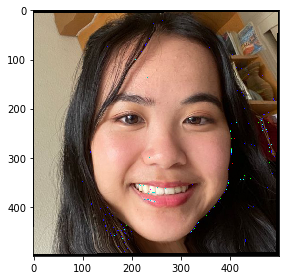

In [ ]:
%matplotlib inline
skio.imshow(m)

# Bells and Whistles 
Morphing Video 

In [77]:
import imageio
    
def morph(im1, im2, im1pts, im2pts, tri, warp_frac, dissolve_frac):
    counter = 0
    images = []

    for i in np.arange(0.025, 1, warp_frac):
        tri1, tri2, mid = get_triangulations(im1pts, im2pts, tri, i)
        warp1 = population_warp(im1, tri1, mid)
        warp2 = population_warp(im2, tri2, mid)
        morph = i*warp1 + (1-i)*warp2
        fname = 'morphing_' + str(counter) + '.jpg'
        skio.imsave(fname, morph.astype(np.uint8))
        images.append(imageio.imread(fname))
        counter+=1
    imageio.mimsave('movie0.gif', images)


In [ ]:
def get_points(im1, im2, im3, im4, im5):
    points1 = []
    points2 = []
    points3 = []
    points4 = []
    points5 = []
    for i in np.arange(50):
#         print('Please select 1 point in each image for alignment.')
        plt.imshow(im1)
        p1 = plt.ginput(1)
        plt.close()
        plt.imshow(im2)
        p2 = plt.ginput(1)
        plt.close()
        plt.imshow(im3)
        p3 = plt.ginput(1)
        plt.close()
        plt.imshow(im4)
        p4 = plt.ginput(1)
        plt.close()
        plt.imshow(im5)
        p5 = plt.ginput(1)
        plt.close()
        points1 = np.append(points1, p1)
        points2 = np.append(points2, p2)
        points3 = np.append(points3, p3)
        points4 = np.append(points4, p4)
        points5 = np.append(points5, p5)
    return (points1, points2, points3, points4, points5)

In [ ]:
#read in images 
megan = skio.imread('squaremegan.jpg')
dad = skio.imread('dad.jpg')
mom = skio.imread('mom.jpg')
uncle = skio.imread('uncle.jpg')
grandma = skio.imread('grandma.jpg')

In [ ]:
# meganpoints, dadpoints, mompoints, unclepoints, grandmapoints = get_points(megan, dad, mom, uncle, grandma)

In [ ]:
#save points 
np.save('meganpoints_bells', meganpoints)
np.save('dadpoints', dadpoints)
np.save('mompoints', mompoints)
np.save('unclepoints', unclepoints)
np.save('grandmapoints', grandmapoints)

In [ ]:
def sequence(im1, im2, points1, points2, alpha): 
    avg = (1-alpha)*points1 + (alpha)*points2
    midwayshape = np.reshape(avg, (-1, 2))
    tri_av = Delaunay(midwayshape)
    p1reshaped = np.reshape(points1, (-1, 2))
    p2reshaped = np.reshape(points2, (-1, 2))
    
    tri1, tri2, mid = triangulations(p1reshaped, p2reshaped, midwayshape, tri_av)
    warp1 = population_warp(im1, tri1, mid)
    warp2 = population_warp(im2, tri2, mid)
    warped = warp1*(1-alpha) + warp2*(alpha)
    return warped.astype(np.uint8)

In [ ]:
def morph2(im1, im2, im1pts, im2pts, warp_frac, name):
    counter = 0
    for i in np.arange(0.025, 1, warp_frac):
        morph = sequence(im1, im2, im1pts, im2pts, i)
        skio.imsave('bells/' + name + str(counter) + '.jpg', morph)
        counter+=1

In [ ]:
#morph sequence: dad to megan, megan to mom, mom to grandma, grandma to uncle 
#run the following to obtain images for gifs 

#dad to megan 
morph2(dad, megan, dadpoints, meganpoints, 0.025, 'dadtomeg_')
morph2(megan, mom, meganpoints, mompoints,  0.025, 'megtomom_')
morph2(mom, grandma, mompoints, grandmapoints, 0.025, 'momtograndma_')
morph2(grandma, uncle, grandmapoints, unclepoints,  0.025, 'grandmatouncle_')

In [ ]:
dadmom = sequence(mom, dad, mompoints, dadpoints, 0.3)

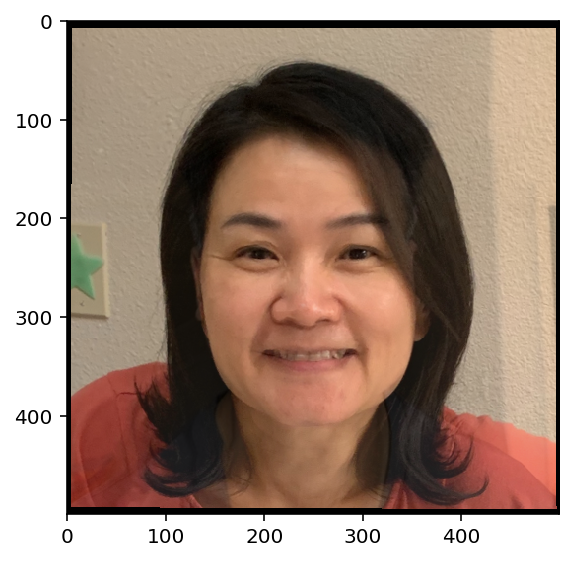

In [ ]:
skio.imshow(dadmom)